In [1]:
import jax
import jax.numpy as jnp
import jaxlie
import mujoco
from mujoco import mjx
from mujoco_logger import SimLog
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH

from mujoco_sysid.mjx.convert import logchol2theta, theta2logchol
from mujoco_sysid.mjx.parameters import get_dynamic_parameters

key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
model = mujoco.MjModel.from_xml_path(MJCF_PATH)
mjx_model = mjx.put_model(model)

data = mujoco.MjData(model)
log = SimLog("quadrotor.json")

true_parameters = get_dynamic_parameters(model, 1)
true_parameters

Array([ 1.325   ,  0.      ,  0.      ,  0.0715  ,  0.04051 ,  0.      ,
        0.02927 , -0.0021  ,  0.      ,  0.060528], dtype=float32)

In [3]:
log_qpos = jnp.array(log.data("qpos"))
log_qvel = jnp.array(log.data("qvel"))
log_x = jnp.concatenate([log_qpos, log_qvel], axis=-1)
log_ctrl = jnp.array(log.data("ctrl"))

log_x.shape, log_ctrl.shape

((1001, 13), (1001, 4))

In [4]:
def diff_x(x1, x2):
    # qpos = [x, y, z, qw, qx, qy, qz]
    qpos1 = x1[:7]
    qpos2 = x2[:7]
    quat1 = qpos1[3:][jnp.array([3, 0, 1, 2])]
    quat2 = qpos2[3:][jnp.array([3, 0, 1, 2])]
    q1 = jaxlie.SO3.from_quaternion_xyzw(quat1)
    q2 = jaxlie.SO3.from_quaternion_xyzw(quat2)

    vel1 = x1[7:]
    vel2 = x2[7:]

    return jnp.concatenate(
        [
            qpos1[:3] - qpos2[:3],
            jaxlie.SO3.log(q1.inverse() @ q2),
            vel1 - vel2,
        ]
    )

In [5]:
from mujoco_sysid.mjx.model import rollout, step

step = jax.jit(step)

In [6]:
theta_estimate = get_dynamic_parameters(model, 1)
logchol = theta2logchol(theta_estimate)
logchol += jax.random.normal(key, logchol.shape) * 0.3
logchol_estimate = logchol

logchol_estimate

Array([ 0.02907295, -2.0457456 , -1.8591964 , -3.9478104 , -0.13209113,
       -0.04564326, -0.13556199, -0.17725924,  0.21950667,  0.22415304],      dtype=float32)

In [7]:
def error_step(logchol_estimate, mjx_model, x, ctrl):
    theta_estimate = logchol2theta(logchol_estimate)
    x_next = step(theta_estimate, mjx_model, x, ctrl)
    return jnp.linalg.norm(diff_x(x_next, x), 2)


jax.value_and_grad(error_step)(logchol_estimate, mjx_model, log_x[0], log_ctrl[0])

(Array(0.21685232, dtype=float32),
 Array([-4.2706367e-01, -9.6768722e-02, -1.3716984e-01,  1.3185101e-02,
         9.8154247e-01, -1.3037524e-01,  6.5588957e-01,  1.1920929e-07,
        -2.3841858e-07,  0.0000000e+00], dtype=float32))

In [8]:
def error_rollout(logchol_estimate, mjx_model, x, ctrls, expected_x):
    theta_estimate = logchol2theta(logchol_estimate)
    x_hist = rollout(theta_estimate, mjx_model, x, ctrls)

    # gamma = 0.98
    # error = 0
    # for i in range(len(x_hist)):
    #     error += gamma**i * jnp.linalg.norm(diff_x(x_hist[i], expected_x), 2)

    # return error
    return jnp.linalg.norm(diff_x(x_hist[-1], expected_x), 2)


error_rollout_compiled = jax.jit(jax.value_and_grad(error_rollout))

In [9]:
import optax

# start_learning_rate = 1e-3
# optimizer = optax.novograd(learning_rate=start_learning_rate)

# parameters = logchol_estimate
# opt_state = optimizer.init(parameters)

In [10]:
horizon = 10

error_rollout_compiled(logchol_estimate, mjx_model, log_x[0], log_ctrl[:horizon], log_x[horizon])

# for i in range(horizon, len(log)):
#     x_start = log_x[i - horizon]
#     ctrls = log_ctrl[i - horizon : i]

#     loss, grad = error_rollout_compiled(parameters, mjx_model, x_start, ctrls, log_x[i])

#     updates, opt_state = optimizer.update(grad, opt_state, parameters)
#     parameters = optax.apply_updates(parameters, updates)

#     # print(f"Step {i}, loss: {loss}")

#     # if i % 10 == 0:
#     #     print(f"Step {i}, loss: {loss}")
#     #     print(logchol2theta(parameters))

(Array(0.8212316, dtype=float32),
 Array([ 1.32471013e+00,  2.55321950e-01,  1.68644384e-01, -1.07282335e-02,
        -4.64640093e+00,  2.76242471e+00, -1.26727557e+00,  0.00000000e+00,
        -2.38418579e-07, -1.19209290e-07], dtype=float32))

In [11]:
# print(f"Optimized theta parameters: {logchol2theta(parameters)}")
# print(f"True theta parameters: {true_parameters}")

# print(f"LogChol distance: {jnp.linalg.norm(parameters - theta2logchol(true_parameters), 2)}")

In [31]:
theta2logchol(true_parameters)


Array([ 0.14070623, -2.125015  , -1.8044381 , -3.7267644 ,  0.        ,
        0.        ,  0.06584406,  0.        ,  0.        ,  0.05396227],      dtype=float32)

# Try same optimization, but batch along each initial guess

- Sample M initial guesses for the solution
- For each initial guess, run the optimization for N steps (parallel)
- Output the history for all results and whether they converge to each other

In [35]:
# sample many initial guesses
M = 100  # number of samples we optimize simultaneously (initial guesses)

initial_guesses = jax.random.normal(key, (M, 10)) * 0.4 + theta2logchol(true_parameters)
initial_guesses = initial_guesses.at[:, jnp.array([4, 5, 7, 8])].set(0.0)
initial_guesses.shape

(100, 10)

In [36]:
optimizer = optax.adam(learning_rate=1e-3)


def optimize_one(guess):
    history_loss = []
    history_parameters = []

    parameters = guess
    opt_state = optimizer.init(parameters)

    for i in range(horizon, len(log)):
        x_start = log_x[i - horizon]
        ctrls = log_ctrl[i - horizon : i]

        loss, grad = error_rollout_compiled(parameters, mjx_model, x_start, ctrls, log_x[i])

        updates, opt_state = optimizer.update(grad, opt_state, parameters)
        parameters = optax.apply_updates(parameters, updates)

        history_loss.append(loss)
        history_parameters.append(parameters)

    return parameters, jnp.array(history_loss), jnp.array(history_parameters)

In [37]:
# optimizer is one, but many guesses
optimize_many = jax.vmap(optimize_one)

In [38]:
results = optimize_many(initial_guesses)

In [39]:
results[1].shape

(100, 991)

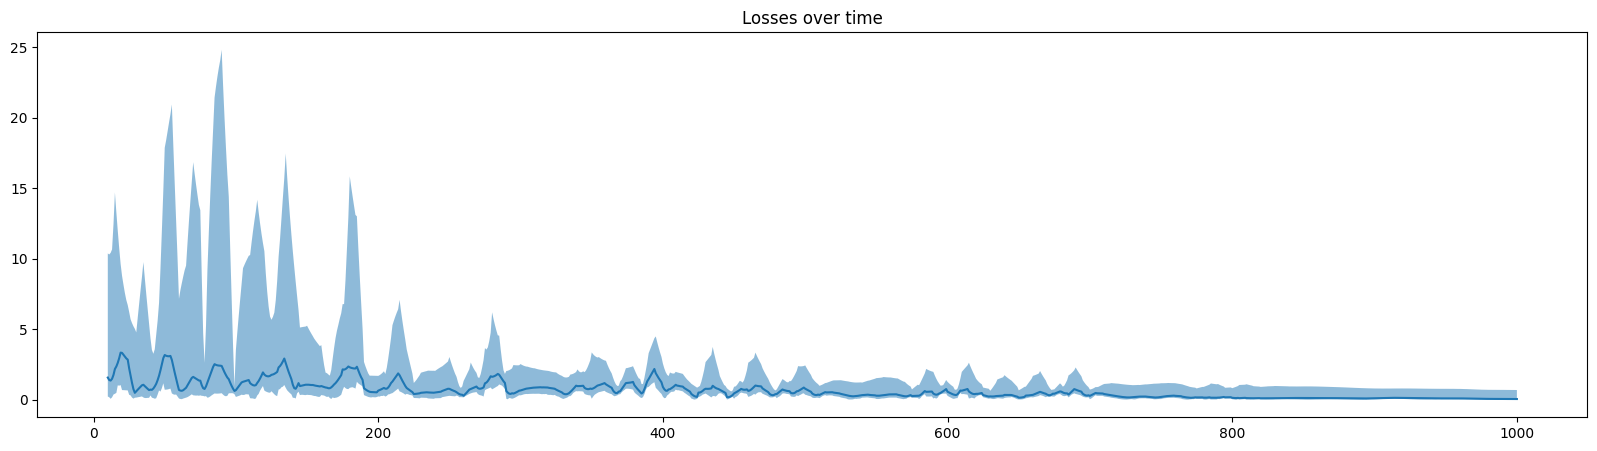

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.title("Losses over time")
plt.fill_between(jnp.arange(horizon, len(log)), results[1].min(axis=0), results[1].max(axis=0), alpha=0.5)
plt.plot(jnp.arange(horizon, len(log)), results[1].mean(axis=0))
plt.show()


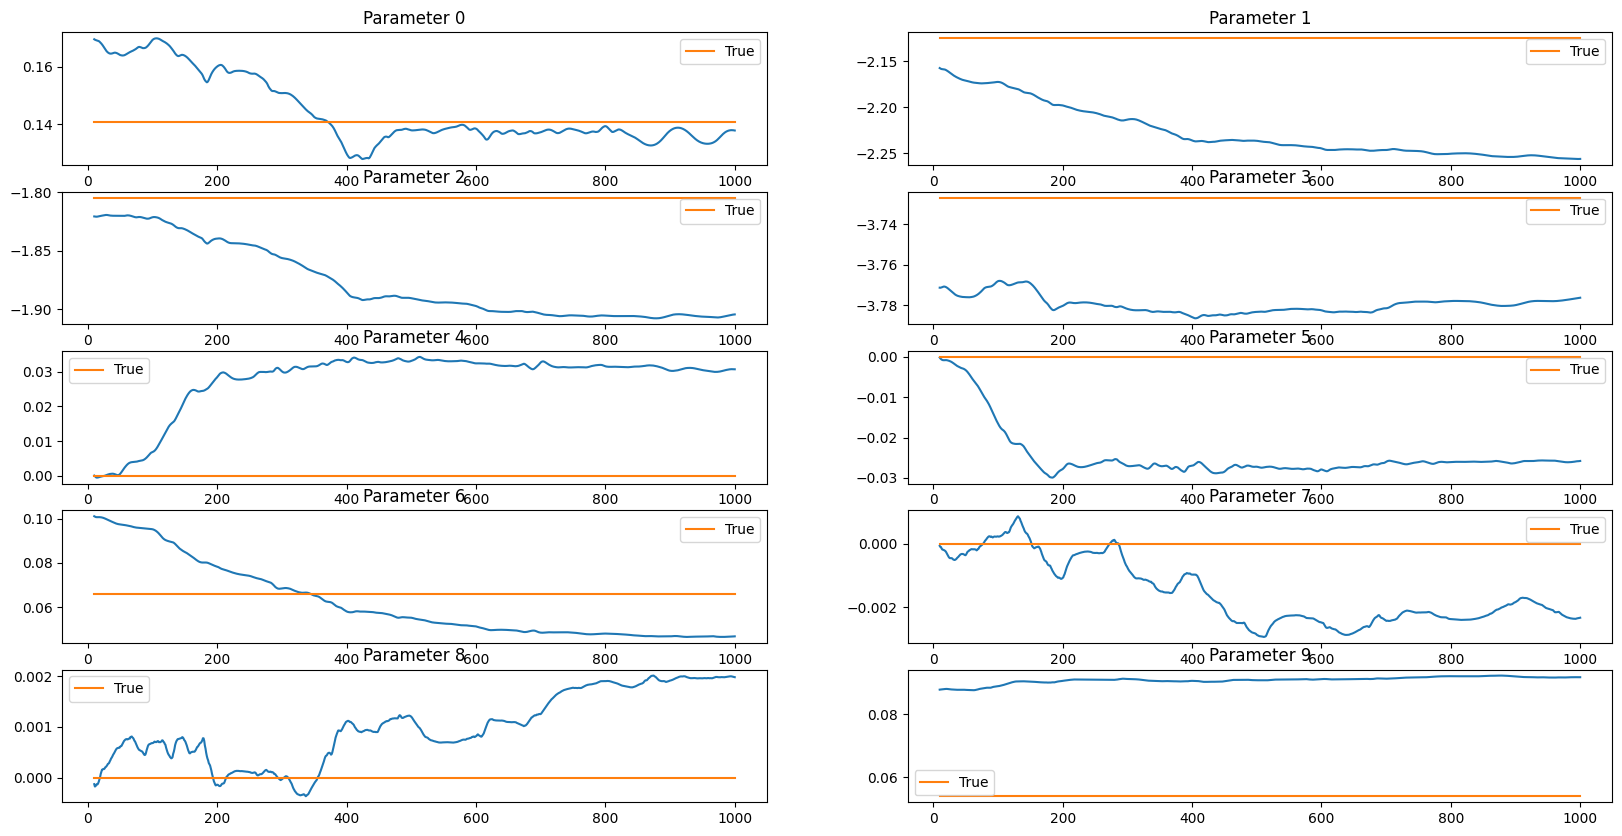

In [41]:
# per each parameter, plot fill_between of min/max and mean
# plot true parameters as a line
logchol_true = theta2logchol(true_parameters)

parameters_history = results[2]  # M x T x 10
# plot each parameter in subplots
plt.figure(figsize=(20, 10))

for i in range(10):
    current_parameter = parameters_history[:, :, i]

    min_parameter = current_parameter.min(axis=0)
    max_parameter = current_parameter.max(axis=0)

    plt.subplot(5, 2, i + 1)
    plt.title(f"Parameter {i}")
    # plt.fill_between(jnp.arange(horizon, len(log)), min_parameter, max_parameter, alpha=0.5)
    plt.plot(jnp.arange(horizon, len(log)), current_parameter.mean(axis=0))
    plt.plot(jnp.arange(horizon, len(log)), jnp.repeat(logchol_true[i], len(log) - horizon), label="True")
    plt.legend()

In [45]:
parameters_history = results[2]  # M x T x 10

vmap_logchol2theta = jax.vmap(logchol2theta)

history = []
for i in range(parameters_history.shape[0]):
    history.append(vmap_logchol2theta(parameters_history[i]))

history = jnp.array(history)


In [46]:
history.shape

(100, 991, 10)

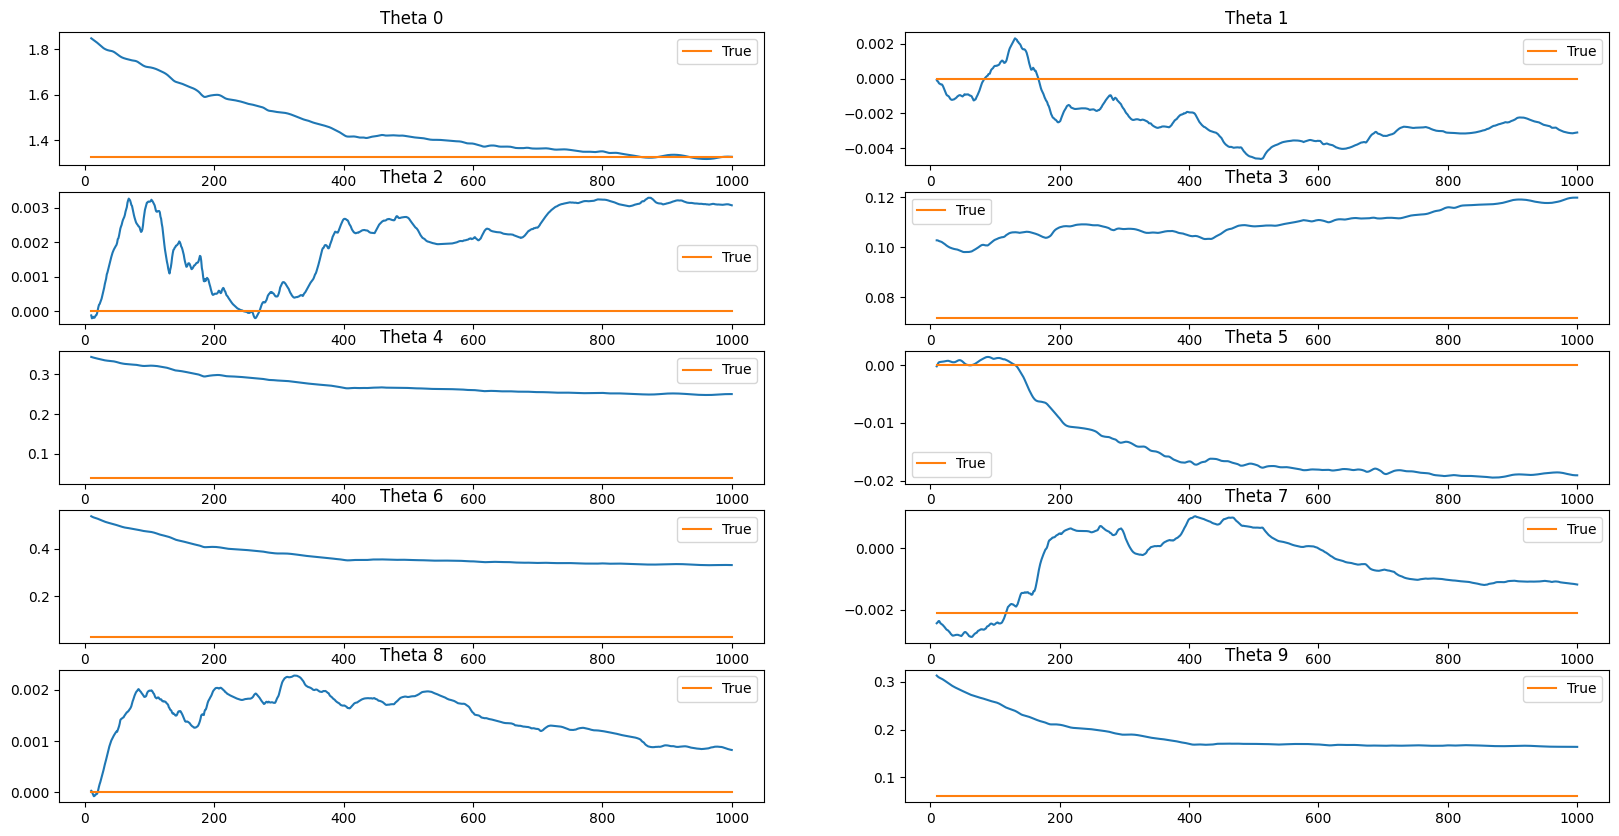

In [50]:
# plot each parameter in subplots
plt.figure(figsize=(20, 10))

for i in range(10):
    current_parameter = history[:, :, i]

    min_parameter = current_parameter.min(axis=0)
    max_parameter = current_parameter.max(axis=0)

    plt.subplot(5, 2, i + 1)
    plt.title(f"Theta {i}")
    # plt.fill_between(jnp.arange(horizon, len(log)), min_parameter, max_parameter, alpha=0.5)
    plt.plot(jnp.arange(horizon, len(log)), current_parameter.mean(axis=0))
    plt.plot(jnp.arange(horizon, len(log)), jnp.repeat(true_parameters[i], len(log) - horizon), label="True")
    plt.legend()
